In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pulp import *
import pandas as pd
import os, glob
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/fa/Downloads/google-cloud-sdk/som-nero-phi-jonc101-2116f9f7bc68.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101' 
%load_ext google.cloud.bigquery

from google.cloud import bigquery
client=bigquery.Client()
from google.cloud import bigquery_storage_v1

# Study Cohort

In [74]:
%%bigquery df_ED
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
with base as (
SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded,
        op.order_proc_id_coded, 
        op.order_time_jittered_utc,
        EXTRACT(YEAR FROM op.order_time_jittered_utc) as order_year ,  
        op.ordering_mode,
        op.department_id,
    
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
     INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND op.description LIKE "%BLOOD%"
        AND not op.order_status like any ('Discontinued','Canceled')
), 
ED_orders as(
select 
b.anon_id,
b.pat_enc_csn_id_coded,
b.order_proc_id_coded,
b.order_time_jittered_utc,
b.order_year,
b.ordering_mode,
b.department_id,
department_name,
from base b inner join `som-nero-phi-jonc101.shc_core_2023.dep_map` using(department_id)
where lower(department_name) like '%emergency%'
group by b.anon_id,b.pat_enc_csn_id_coded,b.order_proc_id_coded,b.order_time_jittered_utc,b.order_year,b.ordering_mode,b.department_id,department_name
)
SELECT 
  b.anon_id,
  b.pat_enc_csn_id_coded,
  b.order_proc_id_coded,
  b.order_time_jittered_utc as blood_culture_order_datetime,
  b.order_year,
  ad.effective_time_jittered_utc as ed_arrival_datetime,
FROM 
  ED_orders b
INNER JOIN 
  `som-nero-phi-jonc101.shc_core_2023.adt` ad
USING 
  (anon_id,pat_enc_csn_id_coded,department_id)
Where event_type='Admission'
and b.order_time_jittered_utc>=ad.effective_time_jittered_utc
GROUP BY b.anon_id,b.pat_enc_csn_id_coded,b.order_proc_id_coded,b.order_time_jittered_utc,b.order_year,ad.effective_time_jittered_utc

Query is running:   0%|          |

# Labels

In [75]:
%%bigquery df_ed_labels
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
With culture as ( 
    SELECT DISTINCT
         c.anon_id,
         c.pat_enc_csn_id_coded,
         c.order_proc_id_coded,
         lr.ord_value,
         coalesce(lr.extended_value_comment,lr.extended_comp_comment) as comment,
    FROM 
        `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
       on c.anon_id=lr.anon_id 
          and c.order_proc_id_coded=lr.order_id_coded
          and c.pat_enc_csn_id_coded=lr.pat_enc_csn_id_coded
          and c.blood_culture_order_datetime=lr.order_time_jittered_utc
    ),
culture_growth as (
select op.anon_id,
       op.pat_enc_csn_id_coded,
       op.order_proc_id_coded,
       1 as was_pos,
from culture op  
                INNER join (SELECT DISTINCT anon_id,order_proc_id_coded, organism
                        FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`
                        where organism is not null) cs USING (anon_id,order_proc_id_coded) 
WHERE not lower(ord_value) like any ("%no%grow%","%not%detect%","negative")
     AND not upper(comment) like any ('%NO%GROWTH%','%COAG%NEG%STAPH%','%GRAM%+%RODS%','%GRAM%POS%RODS%','%CONTAMIN%')
)
select c.*,
case when (cg.was_pos=1) then cg.was_pos else 0 end as positive_blood_culture 
from `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c LEFT JOIN culture_growth cg 
using(anon_id,pat_enc_csn_id_coded,order_proc_id_coded)

Query is running:   0%|          |

In [76]:
positive_blood_culture_in_week_Span1=72
positive_blood_culture_in_week_Span2=168

In [77]:
%%bigquery df_ed_labels
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
With order_posetive_next_week AS (
   SELECT DISTINCT
         c.anon_id,
         c.order_proc_id_coded,
         1 as positive_blood_culture_in_week
    FROM 
       `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c 
     INNER JOIN
        `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c2
    ON
        c.anon_id = c2.anon_id
    WHERE
        c2.positive_blood_culture=1
        AND TIMESTAMP_DIFF(c2.blood_culture_order_datetime,c.blood_culture_order_datetime, Hour) between 72 and 168
        group by anon_id,order_proc_id_coded
)
select c.*,
case when o.positive_blood_culture_in_week=1 then o.positive_blood_culture_in_week else 0 end as positive_blood_culture_in_week
from  `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c  left join order_posetive_next_week o using(anon_id,order_proc_id_coded)

Query is running:   0%|          |

# Earliest Iv Antibiotic

In [78]:
%%bigquery df_ed_labels
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
WITH ED_ABX as (
SELECT
  c.anon_id,
  c.pat_enc_csn_id_coded,
  c.order_proc_id_coded,
  o.med_description,
  o.order_start_time_jittered_utc AS earliest_iv_antibiotic_datetime
FROM
  `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c
INNER JOIN (
    SELECT
      anon_id,
      pat_enc_csn_id_coded,
      med_description,
      order_start_time_jittered_utc,
      RANK() OVER (PARTITION BY anon_id, pat_enc_csn_id_coded ORDER BY order_start_time_jittered_utc ASC) as rank
    FROM
      `som-nero-phi-jonc101.shc_core_2023.order_med`
    WHERE
      thera_class_name IN ('ANTIBIOTICS')
      AND LOWER(med_route) = 'intravenous'
) o ON c.anon_id = o.anon_id AND c.pat_enc_csn_id_coded = o.pat_enc_csn_id_coded
WHERE
  o.rank = 1
  AND TIMESTAMP_DIFF(o.order_start_time_jittered_utc, c.blood_culture_order_datetime, HOUR) BETWEEN -4 AND 24
GROUP BY
  c.anon_id, c.pat_enc_csn_id_coded, c.order_proc_id_coded, o.med_description, o.order_start_time_jittered_utc    
),
ED_ABX_rxcui_str as (
select m.anon_id,
m.pat_enc_csn_id_coded,
m.order_proc_id_coded,
m.earliest_iv_antibiotic_datetime,
mm.rxcui_str as earliest_iv_antibiotic
from ED_ABX m 
inner join `som-nero-phi-jonc101.shc_core_2023.mapped_meds` mm on m.med_description=mm.name
where not rxcui='0'
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,earliest_iv_antibiotic_datetime,earliest_iv_antibiotic
)
select c.*,
ea.earliest_iv_antibiotic_datetime,
ea.earliest_iv_antibiotic
from `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c left join ED_ABX_rxcui_str ea using(anon_id,pat_enc_csn_id_coded,order_proc_id_coded)
group by c.anon_id,c.pat_enc_csn_id_coded,c.order_proc_id_coded,c.blood_culture_order_datetime,c.order_year,c.ed_arrival_datetime,
c.positive_blood_culture,c.positive_blood_culture_in_week,ea.earliest_iv_antibiotic_datetime,ea.earliest_iv_antibiotic


Query is running:   0%|          |

# Vitals

In [79]:
%%bigquery df_ed_features
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
WITH vitals as (
  SELECT c.*,
  vitals.recorded_time_jittered_utc,
  CASE WHEN upper(row_disp_name) IN ('PULSE', 'HEART RATE') THEN round(SAFE_CAST(numerical_val_1 AS FLOAT64),2) end as heartrate,
  CASE WHEN upper(row_disp_name) IN ('RESP', 'RESP RATE') THEN round(SAFE_CAST(numerical_val_1 AS FLOAT64),2) end as resprate,
  CASE WHEN upper(row_disp_name) IN ('TEMP') THEN round(SAFE_CAST(numerical_val_1 AS FLOAT64),2) end as temp,
  CASE WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 40) THEN round(SAFE_CAST(numerical_val_1 AS FLOAT64),2) end as sysbp ,
  CASE WHEN (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30)  THEN round(SAFE_CAST(numerical_val_2 AS FLOAT64),2) end as diasbp,
  FROM
    `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c LEFT JOIN
  `som-nero-phi-jonc101.shc_core_2023.flowsheet` as vitals
   ON vitals.anon_id = c.anon_id
  WHERE
   ((upper(trim(row_disp_name)) IN ('PULSE', 'HEART RATE') AND SAFE_CAST(numerical_val_1 AS numeric) >= 30) OR -- Heart rate
   (upper(trim(row_disp_name)) in ('RESP', 'RESP RATE') AND SAFE_CAST(numerical_val_1 AS numeric) >= 4 AND SAFE_CAST(numerical_val_1 AS numeric) <= 60) OR -- Respiratory rate
   (upper(trim(row_disp_name)) IN ('TEMP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 90) OR -- Temperature in F
   (upper(trim(row_disp_name)) IN ('WEIGHT') AND SAFE_CAST(numerical_val_1 AS numeric) >= 480 AND SAFE_CAST(numerical_val_1 AS numeric) <= 8000)  OR -- Weight 
  (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_1 AS numeric) >= 40) OR -- Systolic BP
   (upper(trim(row_disp_name)) IN ('BP', 'NIBP') AND SAFE_CAST(numerical_val_2 AS numeric) >= 30) -- diastolic BP
  )
  AND
  (TIMESTAMP_DIFF(vitals.recorded_time_jittered_utc, c.blood_culture_order_datetime, hour) between -24 and 2 )
)
select anon_id,
       pat_enc_csn_id_coded,
       order_proc_id_coded,
       blood_culture_order_datetime,
       order_year,
       ed_arrival_datetime,
       positive_blood_culture,
       positive_blood_culture_in_week,
       earliest_iv_antibiotic_datetime,
       earliest_iv_antibiotic,
       ROUND(min(heartrate),2) as min_heartrate,
       ROUND(max(heartrate),2) as max_heartrate,
       ROUND(avg(heartrate),2) as avg_heartrate,
       ROUND(APPROX_QUANTILES(heartrate, 100)[OFFSET(50)],2) AS median_heartrate,
       ROUND(min(resprate),2) as min_resprate,
       ROUND(max(resprate),2) as max_resprate,
       ROUND(avg(resprate),2) as avg_resprate,
       ROUND(APPROX_QUANTILES(resprate, 100)[OFFSET(50)],2) AS median_resprate,
       ROUND(min(temp),2) as min_temp,
       ROUND(max(temp),2) as max_temp,
       ROUND(avg(temp),2) as avg_temp,
       ROUND(APPROX_QUANTILES(temp, 100)[OFFSET(50)],2) AS median_temp,
       ROUND(min(sysbp),2) as min_sysbp,
       ROUND(max(sysbp),2) as max_sysbp,
       ROUND(avg(sysbp),2) as avg_sysbp,
       ROUND(APPROX_QUANTILES(sysbp, 100)[OFFSET(50)],2) AS median_sysbp,
       ROUND(min(diasbp),2) as min_diasbp,
       ROUND(max(diasbp),2) as max_diasbp,
       ROUND(avg(diasbp)) as avg_diasbp,
       ROUND(APPROX_QUANTILES(diasbp, 100)[OFFSET(50)]) AS median_diasbp,
from vitals
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,blood_culture_order_datetime,order_year,ed_arrival_datetime,positive_blood_culture,positive_blood_culture_in_week,earliest_iv_antibiotic_datetime,earliest_iv_antibiotic

Query is running:   0%|          |

# Labs

In [80]:
%%bigquery df_ed_features
CREATE OR REPLACE TABLE som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
WITH labs AS (
    SELECT 
        c.*,
        CASE 
            WHEN (LOWER(lr.base_name) = 'wbc' AND LOWER(lr.reference_unit) IN ('thousand/ul','k/ul','10x3/ul','10*3/ul','x10e3/ul')) THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'wbc' AND lr.reference_unit = '/uL' THEN SAFE_CAST(lr.ord_value AS FLOAT64)/1000
        END AS wbc,
        CASE 
            WHEN LOWER(lr.lab_name) LIKE '%neutrophils%' AND lr.reference_unit = '%' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS neutrophils,
        CASE 
            WHEN LOWER(lr.lab_name) LIKE '%lymphocytes%' AND lr.reference_unit = '%' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS lymphocytes,
        -- CASE WHEN LOWER(lr.base_name) LIKE '%bands%' THEN SAFE_CAST(lr.ord_value AS FLOAT64) END AS bands,
        CASE 
            WHEN LOWER(lr.base_name) = 'hgb' AND lr.reference_unit = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'hgb' AND LOWER(lr.reference_unit) = 'g/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64) * 1000
        END AS hgb,
        CASE 
            WHEN LOWER(lr.base_name) = 'plt' AND LOWER(lr.reference_unit) IN ('x10e3/ul','10x3/ul','k/ul','10*3/ul','thousand/ul') THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'plt' AND LOWER(lr.reference_unit) = 'ul' THEN SAFE_CAST(lr.ord_value AS FLOAT64) / 1000
        END AS plt,
        CASE 
            WHEN LOWER(lr.base_name) = 'na' AND LOWER(lr.reference_unit) = 'mmol/l' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS na,
        CASE 
            WHEN (LOWER(lr.base_name) = 'hco3' AND LOWER(lr.reference_unit) like any ('meq/l','mmol/l')) THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN (LOWER(lr.base_name) = 'co2' AND LOWER(lr.reference_unit) like any ('meq/l','mmol/l')) THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS hco3,      
        CASE 
            WHEN LOWER(lr.base_name) = 'bun' AND LOWER(lr.reference_unit) = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS bun,
        CASE 
            WHEN LOWER(lr.base_name) = 'cr' AND LOWER(lr.reference_unit) = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS cr,
        -- CASE WHEN LOWER(lr.base_name) LIKE 'glucose' THEN SAFE_CAST(lr.ord_value AS FLOAT64) END AS glucose,
        CASE 
            WHEN LOWER(lr.base_name) = 'lac' AND LOWER(lr.reference_unit) IN ('mmol/l', 'mmole/l') THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS lactate,               
        CASE 
            WHEN LOWER(lr.base_name) = 'crp' AND LOWER(lr.reference_unit) = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'crp' AND LOWER(lr.reference_unit) = 'mg/l' THEN SAFE_CAST(lr.ord_value AS FLOAT64) / 10
        END AS crp,
        CASE 
            WHEN LOWER(lr.lab_name) LIKE 'procalcitonin' AND LOWER(lr.reference_unit) = 'ng/ml' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS procalcitonin
    FROM `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c
    LEFT JOIN `som-nero-phi-jonc101.shc_core_2023.lab_result` lr 
    USING (anon_id, pat_enc_csn_id_coded)
    WHERE TIMESTAMP_DIFF(lr.order_time_jittered_utc, c.blood_culture_order_datetime, HOUR) BETWEEN -24 AND 2
)
SELECT 
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    blood_culture_order_datetime,
    order_year,
    ed_arrival_datetime,
    positive_blood_culture,
    positive_blood_culture_in_week,
    earliest_iv_antibiotic_datetime,
    earliest_iv_antibiotic,
    min_heartrate,
    max_heartrate,
    avg_heartrate,
    median_heartrate,
    min_resprate, 
    max_resprate, 
    avg_resprate,
    median_resprate,
    min_temp, 
    max_temp, 
    avg_temp,
    median_temp,
    min_sysbp,
    max_sysbp, 
    avg_sysbp,
    median_sysbp,
    min_diasbp,
    max_diasbp, 
    avg_diasbp,
    median_diasbp,

    ROUND(MIN(wbc), 2) AS min_wbc,
    ROUND(MAX(wbc), 2) AS max_wbc,
    ROUND(AVG(wbc), 2) AS avg_wbc,
    ROUND(APPROX_QUANTILES(wbc, 100)[OFFSET(50)], 2) AS median_wbc,
    
    ROUND(MIN(neutrophils), 2) AS min_neutrophils,
    ROUND(MAX(neutrophils), 2) AS max_neutrophils,
    ROUND(AVG(neutrophils), 2) AS avg_neutrophils,
    ROUND(APPROX_QUANTILES(neutrophils, 100)[OFFSET(50)], 2) AS median_neutrophils,
    
    ROUND(MIN(lymphocytes), 2) AS min_lymphocytes,
    ROUND(MAX(lymphocytes), 2) AS max_lymphocytes,
    ROUND(AVG(lymphocytes), 2) AS avg_lymphocytes,
    ROUND(APPROX_QUANTILES(lymphocytes, 100)[OFFSET(50)], 2) AS median_lymphocytes,
    
    #ROUND(MIN(bands), 2) AS min_bands,
    #ROUND(MAX(bands), 2) AS max_bands,
    #ROUND(AVG(bands), 2) AS avg_bands,
    #ROUND(APPROX_QUANTILES(bands, 100)[OFFSET(50)], 2) AS median_bands,
    
    ROUND(MIN(hgb), 2) AS min_hgb,
    ROUND(MAX(hgb), 2) AS max_hgb,
    ROUND(AVG(hgb), 2) AS avg_hgb,
    ROUND(APPROX_QUANTILES(hgb, 100)[OFFSET(50)], 2) AS median_hgb,

    ROUND(MIN(plt), 2) AS min_plt,
    ROUND(MAX(plt), 2) AS max_plt,
    ROUND(AVG(plt), 2) AS avg_plt,
    ROUND(APPROX_QUANTILES(plt, 100)[OFFSET(50)], 2) AS median_plt,

    ROUND(MIN(na), 2) AS min_na,
    ROUND(MAX(na), 2) AS max_na,
    ROUND(AVG(na), 2) AS avg_na,
    ROUND(APPROX_QUANTILES(na, 100)[OFFSET(50)], 2) AS median_na,

    ROUND(MIN(hco3), 2) AS min_hco3,
    ROUND(MAX(hco3), 2) AS max_hco3,
    ROUND(AVG(hco3), 2) AS avg_hco3,
    ROUND(APPROX_QUANTILES(hco3, 100)[OFFSET(50)], 2) AS median_hco3,

    ROUND(MIN(bun), 2) AS min_bun,
    ROUND(MAX(bun), 2) AS max_bun,
    ROUND(AVG(bun), 2) AS avg_bun,
    ROUND(APPROX_QUANTILES(bun, 100)[OFFSET(50)], 2) AS median_bun,

    ROUND(MIN(cr), 2) AS min_cr,
    ROUND(MAX(cr), 2) AS max_cr,
    ROUND(AVG(cr), 2) AS avg_cr,
    ROUND(APPROX_QUANTILES(cr, 100)[OFFSET(50)], 2) AS median_cr,

    #ROUND(MIN(glucose), 2) AS min_glucose,
    #ROUND(MAX(glucose), 2) AS max_glucose,
    #ROUND(AVG(glucose), 2) AS avg_glucose,
    #ROUND(APPROX_QUANTILES(glucose, 100)[OFFSET(50)], 2) AS median_glucose,

    ROUND(MIN(lactate), 2) AS min_lactate,
    ROUND(MAX(lactate), 2) AS max_lactate,
    ROUND(AVG(lactate), 2) AS avg_lactate,
    ROUND(APPROX_QUANTILES(lactate, 100)[OFFSET(50)], 2) AS median_lactate,

    ROUND(MIN(procalcitonin), 2) AS min_procalcitonin,
    ROUND(MAX(procalcitonin), 2) AS max_procalcitonin,
    ROUND(AVG(procalcitonin), 2) AS avg_procalcitonin,
    ROUND(APPROX_QUANTILES(procalcitonin, 100)[OFFSET(50)], 2) AS median_procalcitonin

FROM labs
GROUP BY 
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    blood_culture_order_datetime,
    order_year,
    ed_arrival_datetime,
    positive_blood_culture,
    positive_blood_culture_in_week,
    earliest_iv_antibiotic_datetime,
    earliest_iv_antibiotic,
    min_heartrate,
    max_heartrate,
    avg_heartrate,
    median_heartrate,
    min_resprate, 
    max_resprate, 
    avg_resprate,
    median_resprate,
    min_temp, 
    max_temp, 
    avg_temp,
    median_temp,
    min_sysbp,
    max_sysbp, 
    avg_sysbp,
    median_sysbp,
    min_diasbp,
    max_diasbp, 
    avg_diasbp,
    median_diasbp

Query is running:   0%|          |

# demographics

In [81]:
%%bigquery demo_df
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
with demos as (
    SELECT c.*,
           demo.gender,
           demo.canonical_race as race,
          case when demo.birth_date_jittered is not null then DATE_DIFF(CAST(c.blood_culture_order_datetime AS DATE), CAST(demo.birth_date_jittered AS DATE), YEAR)
                else null end AS age,
    FROM 
        `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    ON 
        c.anon_id = demo.anon_id
)
select * from demos where (age is null or age>=18)

Query is running:   0%|          |

# ICD codes

In [101]:
%%bigquery icds 
Create or replace table som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
with icds as (
select *,
case when icd10 like any ('R78.81') or icd9 like any('790.7') then 1 end as bacteremia,
case when icd10 like any ('A41.9','R65.21','Z86.19') or icd9 like any('038.9','995.91','785.52','995.2') then 1 end as septic_shock,
case when icd10 like any ('I33.0') or icd9 like any('421.0') then 1 end as infective_endocarditis,
case when icd10 like any ('I80.9') or icd9 like any('451.9') then 1 end as septic_thrombophlebitis,
case when icd10 like any ('T82.7%A') or icd9 like any('996.61','996.62') then 1 end as vascular_graft_infection,
case when icd10 like any ('T80.211A') or icd9 like any('999.32') then 1 end as CRBSI,
case when icd10 like any ('M46.40') or icd9 like any('722.9') then 1 end as infectious_discitis,
case when icd10 like any ('G06.2','B96.89') or icd9 like any('041.89') then 1 end as epidural_abscess,
case when icd10 like any ('M00.9') or icd9 like any('711.00') then 1 end as septic_arthritis,
case when icd10 like any ('G03.9') or icd9 like any('322.9') then 1 end as meningitis,
case when icd10 like any ('G00.9') or icd9 like any('320.82','320.9') then 1 end as meningitis_bacteria,
case when icd10 like any ('K83.0') or icd9 like any('576.1') then 1 end as cholangitis,
case when icd10 like any ('K83.09','B96.89') or icd9 like any('576.1') then 1 else 0 end as bacterial_cholangitis,
case when icd10 like any ('N12') or icd9 like any('590.80') then 1 else 0 end as pyelonephritis,
case when icd10 like any ('N10','B96.89') or icd9 like any('590.10','590.11') then 1 else 0 end as acute_bacterial_pyelonephritis,
case when icd10 like any ('L03.90') or icd9 like any('486.0') then 1 else 0 end as severe_pneumonia,
case when icd10 like any ('M86.9') or icd9 like any('730.20','730.30','730.90','730.98') then 1 else 0 end as acute_hematogenous_osteomyelitis,
case when icd10 like any ('Q89.01') or icd9 like any('759.0') then 1 else 0 end as asplenia,
case when icd10 like any ('D84.9') or icd9 like any('279.3') then 1 else 0 end as immunocompromised_state,
case when icd10 like any ('L03.90') then 1 else 0 end as severe_cellulitis,
case when icd10 like any ('N30.90') or icd9 like any('595.9') then 1 else 0 end as cystitis,
case when icd10 like any ('N41.9') or icd9 like any('601.9') then 1 else 0 end as prostatitis,
case when icd10 like any ('J18.9') or icd9 like any('486') then 1 else 0 end as CAP,
case when icd10 like any ('E11.69','L08.9') or icd9 like any('250.80','686.9') then 1 else 0 end as diabetic_foot_infection,
case when icd10 like any ('A09','A04.72') or icd9 like any('686.9') then 1 else 0 end as colitis,
case when icd10 like any ('J69.0') or icd9 like any('507.0') then 1 else 0 end as aspiration_pneumonia,
case when icd10 like any ('K81.9') or icd9 like any('575.10') then 1 else 0 end as uncomplicated_cholecystitis,
case when icd10 like any ('K57.92') or icd9 like any('562.11') then 1 else 0 end as uncomplicated_diverticulitis,
case when icd10 like any ('K85.9') or icd9 like any('577.0') then 1 else 0 end as Uncomplicated_pancreatitis,
from som-nero-phi-jonc101.blood_culture_stewardship.cohort c
left join 
som-nero-phi-jonc101.shc_core_2023.diagnosis diag
using (anon_id)
WHERE  DATE_DIFF(CAST(c.blood_culture_order_datetime AS DATE), CAST(diag.start_date_jittered_utc AS DATE), Day) between -6 and 15
)
select anon_id,
pat_enc_csn_id_coded,
order_proc_id_coded,
blood_culture_order_datetime,
order_year,
ed_arrival_datetime,
positive_blood_culture,
positive_blood_culture_in_week,
earliest_iv_antibiotic_datetime,
min_heartrate,
max_heartrate,
avg_heartrate,
median_heartrate,
min_resprate,
max_resprate,
avg_resprate,
median_resprate,
min_temp,
max_temp,
avg_temp,
median_temp,
min_sysbp,
max_sysbp,
avg_sysbp,
median_sysbp,
min_diasbp,
max_diasbp,
avg_diasbp,
median_diasbp,
min_wbc,
max_wbc,
avg_wbc,
median_wbc,
min_neutrophils,
max_neutrophils,
avg_neutrophils,
median_neutrophils,
min_lymphocytes,
max_lymphocytes,
avg_lymphocytes,
median_lymphocytes,
min_hgb,
max_hgb,
avg_hgb,
median_hgb,
min_plt,
max_plt,
avg_plt,
median_plt,
min_na,
max_na,
avg_na,
median_na,
min_hco3,
max_hco3,
avg_hco3,
median_hco3,
min_bun,
max_bun,
avg_bun,
median_bun,
min_cr,
max_cr,
avg_cr,
median_cr,
min_lactate,
max_lactate,
avg_lactate,
median_lactate,
min_procalcitonin,
max_procalcitonin,
avg_procalcitonin,
median_procalcitonin,
gender,
race,
age,
max(bacteremia) as bacteremia,
max(septic_shock) as septic_shock,
max(infective_endocarditis) as infective_endocarditis,
max(septic_thrombophlebitis) as septic_thrombophlebitis,
max(vascular_graft_infection) as vascular_graft_infection,
max(CRBSI) as CRBSI,
max(infectious_discitis) as infectious_discitis,
max(epidural_abscess) as epidural_abscess,
max(septic_arthritis) as septic_arthritis,
max(meningitis) as meningitis,
max(meningitis_bacteria) as meningitis_bacteria,
max(cholangitis) as cholangitis,
max(bacterial_cholangitis) as bacterial_cholangitis,
max(pyelonephritis) as pyelonephritis,
max(acute_bacterial_pyelonephritis) as acute_bacterial_pyelonephritis,
max(severe_pneumonia) as severe_pneumonia,
max(acute_hematogenous_osteomyelitis) as acute_hematogenous_osteomyelitis,
max(asplenia) as asplenia,
max(immunocompromised_state) as immunocompromised_state,
max(severe_cellulitis) as severe_cellulitis,
max(cystitis) as cystitis,
max(prostatitis) as prostatitis,
max(CAP) as CAP,
max(diabetic_foot_infection) as diabetic_foot_infection,
max(colitis) as colitis,
max(aspiration_pneumonia) as aspiration_pneumonia,
max(uncomplicated_cholecystitis) as uncomplicated_cholecystitis,
max(uncomplicated_diverticulitis) as uncomplicated_diverticulitis,
max(Uncomplicated_pancreatitis) as Uncomplicated_pancreatitis
from icds
group by anon_id,
pat_enc_csn_id_coded,
order_proc_id_coded,
blood_culture_order_datetime,
order_year,
ed_arrival_datetime,
positive_blood_culture,
positive_blood_culture_in_week,
earliest_iv_antibiotic_datetime,
min_heartrate,
max_heartrate,
avg_heartrate,
median_heartrate,
min_resprate,
max_resprate,
avg_resprate,
median_resprate,
min_temp,
max_temp,
avg_temp,
median_temp,
min_sysbp,
max_sysbp,
avg_sysbp,
median_sysbp,
min_diasbp,
max_diasbp,
avg_diasbp,
median_diasbp,
min_wbc,
max_wbc,
avg_wbc,
median_wbc,
min_neutrophils,
max_neutrophils,
avg_neutrophils,
median_neutrophils,
min_lymphocytes,
max_lymphocytes,
avg_lymphocytes,
median_lymphocytes,
min_hgb,
max_hgb,
avg_hgb,
median_hgb,
min_plt,
max_plt,
avg_plt,
median_plt,
min_na,
max_na,
avg_na,
median_na,
min_hco3,
max_hco3,
avg_hco3,
median_hco3,
min_bun,
max_bun,
avg_bun,
median_bun,
min_cr,
max_cr,
avg_cr,
median_cr,
min_lactate,
max_lactate,
avg_lactate,
median_lactate,
min_procalcitonin,
max_procalcitonin,
avg_procalcitonin,
median_procalcitonin,
gender,
race,
age;

Query is running:   0%|          |

# VANC + OZYSN 

In [36]:
%%bigquery df_ed_labels
CREATE OR REPLACE TABLE som-nero-phi-jonc101.blood_culture_stewardship.cohort AS
With ED_ABX as(
SELECT
    c.anon_id,
    c.pat_enc_csn_id_coded,
    c.order_proc_id_coded,
    o.med_description
  FROM
    `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c
  INNER JOIN (
      SELECT
        anon_id,
        pat_enc_csn_id_coded,
        med_description,
        order_start_time_jittered_utc
      FROM
        `som-nero-phi-jonc101.shc_core_2023.order_med`
      WHERE
        thera_class_name IN ('ANTIBIOTICS')
        AND LOWER(med_route) = 'intravenous'
  ) o ON c.anon_id = o.anon_id AND c.pat_enc_csn_id_coded = o.pat_enc_csn_id_coded
  WHERE
    TIMESTAMP_DIFF(o.order_start_time_jittered_utc, c.blood_culture_order_datetime, HOUR) BETWEEN -4 AND 24
),
ED_ABX_rxcui_str AS (
 SELECT 
    m.anon_id,
    m.pat_enc_csn_id_coded,
    m.order_proc_id_coded,
    MAX(CASE WHEN LOWER(rxcui_str) LIKE 'vancomycin' THEN 1 ELSE 0 END) AS vanc,
    MAX(CASE WHEN LOWER(rxcui_str) LIKE ANY ('tazobactam', 'piperacillin', 'glucose') THEN 1 ELSE 0 END) AS zosyn
  FROM 
    ED_ABX m 
  INNER JOIN 
    `som-nero-phi-jonc101.shc_core_2023.mapped_meds` mm 
  ON 
    m.med_description = mm.name
  WHERE 
    rxcui != '0'
    AND (LOWER(rxcui_str) LIKE 'vancomycin' OR 
         UPPER(name) LIKE '%ZOSYN%' OR 
         UPPER(name) LIKE '%PIPERACILLIN-TAZOBACTAM%')
  GROUP BY 
    m.anon_id, m.pat_enc_csn_id_coded,m.order_proc_id_coded
)
SELECT 
  c.*,
  CASE WHEN ea.vanc = 1 THEN 1 ELSE 0 END AS vanc,
  CASE WHEN ea.zosyn = 1 THEN 1 ELSE 0 END AS zosyn,
  CASE WHEN ea.vanc = 1 AND ea.zosyn = 1 THEN 1 ELSE 0 END AS vanc_zosyn,
  CASE WHEN (ea.vanc = 0  or ea.vanc is null or ea.zosyn = 0 or  ea.zosyn is null) AND c.earliest_iv_antibiotic_datetime IS NOT NULL THEN 1 ELSE 0 END AS other_ABX
FROM 
  `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c 
LEFT JOIN 
  ED_ABX_rxcui_str  ea
USING (anon_id, pat_enc_csn_id_coded,order_proc_id_coded)

Query is running:   0%|          |

In [196]:
df_ed_labels.columns.values

array(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'blood_culture_order_datetime', 'order_year',
       'ed_arrival_datetime', 'positive_blood_culture',
       'positive_blood_culture_in_week',
       'earliest_iv_antibiotic_datetime', 'min_heartrate',
       'max_heartrate', 'avg_heartrate', 'median_heartrate',
       'min_resprate', 'max_resprate', 'avg_resprate', 'median_resprate',
       'min_temp', 'max_temp', 'avg_temp', 'median_temp', 'min_sysbp',
       'max_sysbp', 'avg_sysbp', 'median_sysbp', 'min_diasbp',
       'max_diasbp', 'avg_diasbp', 'median_diasbp', 'min_wbc', 'max_wbc',
       'avg_wbc', 'median_wbc', 'min_neutrophils', 'max_neutrophils',
       'avg_neutrophils', 'median_neutrophils', 'min_lymphocytes',
       'max_lymphocytes', 'avg_lymphocytes', 'median_lymphocytes',
       'min_hgb', 'max_hgb', 'avg_hgb', 'median_hgb', 'min_plt',
       'max_plt', 'avg_plt', 'median_plt', 'min_na', 'max_na', 'avg_na',
       'median_na', 'min_hco3', 'max_hco3

# test

## LAB Reports

In [35]:
%%bigquery df_ed_labs
SELECT 
       c.anon_id,
    c.pat_enc_csn_id_coded,
    c.order_proc_id_coded,
    c.blood_culture_order_datetime,
    c.order_year,
    c.ed_arrival_datetime,
    c.positive_blood_culture,
    c.positive_blood_culture_in_week,
    c.earliest_iv_antibiotic_datetime,
    c.earliest_iv_antibiotic,
        CASE 
            WHEN (LOWER(lr.base_name) = 'wbc' AND LOWER(lr.reference_unit) IN ('thousand/ul','k/ul','10x3/ul','10*3/ul','x10e3/ul')) THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'wbc' AND lr.reference_unit = '/uL' THEN SAFE_CAST(lr.ord_value AS FLOAT64)/1000
        END AS wbc,
        CASE 
            WHEN LOWER(lr.lab_name) LIKE '%neutrophils%' AND lr.reference_unit = '%' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS neutrophils,
        CASE 
            WHEN LOWER(lr.lab_name) LIKE '%lymphocytes%' AND lr.reference_unit = '%' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS lymphocytes,
        -- CASE WHEN LOWER(lr.base_name) LIKE '%bands%' THEN SAFE_CAST(lr.ord_value AS FLOAT64) END AS bands,
        CASE 
            WHEN LOWER(lr.base_name) = 'hgb' AND lr.reference_unit = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'hgb' AND LOWER(lr.reference_unit) = 'g/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64) * 1000
        END AS hgb,
        CASE 
            WHEN LOWER(lr.base_name) = 'plt' AND LOWER(lr.reference_unit) IN ('x10e3/ul','10x3/ul','k/ul','10*3/ul','thousand/ul') THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'plt' AND LOWER(lr.reference_unit) = 'ul' THEN SAFE_CAST(lr.ord_value AS FLOAT64) / 1000
        END AS plt,
        CASE 
            WHEN LOWER(lr.base_name) = 'na' AND LOWER(lr.reference_unit) = 'mmol/l' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS na,
        CASE 
            WHEN LOWER(lr.base_name) = 'hco3' AND LOWER(lr.reference_unit) = 'meq/l' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS hco3,      
        CASE 
            WHEN LOWER(lr.base_name) = 'bun' AND LOWER(lr.reference_unit) = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS bun,
        CASE 
            WHEN LOWER(lr.base_name) = 'cr' AND LOWER(lr.reference_unit) = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS cr,
        -- CASE WHEN LOWER(lr.base_name) LIKE 'glucose' THEN SAFE_CAST(lr.ord_value AS FLOAT64) END AS glucose,
        CASE 
            WHEN LOWER(lr.base_name) = 'lac' AND LOWER(lr.reference_unit) IN ('mmol/l', 'mmole/l') THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS lactate,               
        CASE 
            WHEN LOWER(lr.base_name) = 'crp' AND LOWER(lr.reference_unit) = 'mg/dl' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
            WHEN LOWER(lr.base_name) = 'crp' AND LOWER(lr.reference_unit) = 'mg/l' THEN SAFE_CAST(lr.ord_value AS FLOAT64) / 10
        END AS crp,
        CASE 
            WHEN LOWER(lr.lab_name) LIKE 'procalcitonin' AND LOWER(lr.reference_unit) = 'ng/ml' THEN SAFE_CAST(lr.ord_value AS FLOAT64)
        END AS procalcitonin
    FROM `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c
    LEFT JOIN `som-nero-phi-jonc101.shc_core_2023.lab_result` lr 
    USING (anon_id, pat_enc_csn_id_coded)
    WHERE TIMESTAMP_DIFF(lr.order_time_jittered_utc, c.blood_culture_order_datetime, HOUR) BETWEEN -24 AND 2
    and c.order_year>=2022

group by anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    blood_culture_order_datetime,
    order_year,
    ed_arrival_datetime,
    positive_blood_culture,
    positive_blood_culture_in_week,
    earliest_iv_antibiotic_datetime,
    earliest_iv_antibiotic,
    lab_name,
    base_name,
    ord_value,
    reference_unit


Query is running:   0%|          |

Downloading:   0%|          |

In [36]:
df_ed_labs.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,blood_culture_order_datetime,order_year,ed_arrival_datetime,positive_blood_culture,positive_blood_culture_in_week,earliest_iv_antibiotic_datetime,earliest_iv_antibiotic,...,lymphocytes,hgb,plt,na,hco3,bun,cr,lactate,crp,procalcitonin
0,JC835605,131333859457,797977314,2022-05-11 18:09:00+00:00,2022,2022-05-11 17:24:00+00:00,1,0,NaT,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC3240533,131345110745,837247142,2022-11-29 22:41:00+00:00,2022,2022-11-29 16:56:00+00:00,0,0,2022-11-29 22:06:00+00:00,Vancomycin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC2235684,131355968375,881963268,2023-06-25 20:13:00+00:00,2023,2023-06-25 18:22:00+00:00,0,0,NaT,None,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JC6284183,131335800231,804166143,2022-06-28 02:26:00+00:00,2022,2022-06-28 02:19:00+00:00,1,0,2022-06-28 02:36:00+00:00,Vancomycin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JC6447295,131361803336,903022486,2023-08-31 22:53:00+00:00,2023,2023-08-31 17:42:00+00:00,0,0,NaT,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
pos.hco3.unique()

array([ nan, 30.8])

In [45]:
pos=df_ed_labs[(df_ed_labs.positive_blood_culture==1)|(df_ed_labs.positive_blood_culture_in_week==1)]
neg=df_ed_labs[(df_ed_labs.positive_blood_culture==0)&(df_ed_labs.positive_blood_culture_in_week==0)]


In [41]:
for lab in [ 'wbc',
       'neutrophils', 'lymphocytes', 'hgb', 'plt', 'na', 'hco3', 'bun', 'cr',
       'lactate', 'crp', 'procalcitonin']:
    print('LAB:',lab,pos[pos[lab].notna()][lab].mean(),pos[pos[lab].notna()][lab].median(),pos[pos[lab].notna()][lab].min(),pos[pos[lab].notna()][lab].max())
    print('*******')

LAB: wbc 13.12418048592364 11.3 0.1 333.2
*******
LAB: neutrophils 40.815377697841726 37.0 0.0 97.0
*******
LAB: lymphocytes 9.867727272727274 4.3 0.0 100.0
*******
LAB: hgb 11036.916208791208 11000.0 3800.0 19000.0
*******
LAB: plt 233.96998845709888 211.0 2.0 1429.0
*******
LAB: na 134.37629037629037 135.0 107.0 168.0
*******
LAB: hco3 30.8 30.8 30.8 30.8
*******
LAB: bun 28.814623338257014 22.0 4.0 222.0
*******
LAB: cr 1.5940303779583185 1.04 0.07 18.6
*******
LAB: lactate 2.6116165413533836 2.1 0.31 11.32
*******
LAB: crp 13.697767857142859 10.9 0.4 46.9
*******
LAB: procalcitonin 5.680523255813952 0.895 0.03 100.0
*******


In [51]:
for lab in [ 'wbc',
       'neutrophils', 'lymphocytes', 'hgb', 'plt', 'na', 'hco3', 'bun', 'cr',
       'lactate', 'crp', 'procalcitonin']:
    print('LAB:',lab,neg[neg[lab].notna()][lab].mean(),neg[neg[lab].notna()][lab].median(),neg[neg[lab].notna()][lab].min(),neg[neg[lab].notna()][lab].max())
    print('*******')

LAB: wbc 11.883643004385661 10.1 0.1 848.8
*******
LAB: neutrophils 34.0348878249629 25.2 0.0 100.0
*******
LAB: lymphocytes 16.74292827247799 8.7 0.0 100.0
*******
LAB: hgb 11732.85505993471 11800.0 2300.0 25000.0
*******
LAB: plt 268.34232321971115 248.0 1.0 1775.0
*******
LAB: na 135.7498135904956 136.0 100.0 177.0
*******
LAB: hco3 24.63846153846153 24.3 16.0 31.9
*******
LAB: bun 23.812885941999866 18.0 2.0 250.0
*******
LAB: cr 1.3488277379589 0.9 0.06 24.16
*******
LAB: lactate 2.2278197976031158 1.61 0.3 20.7
*******
LAB: crp 7.742435118718939 4.7 0.1 56.4
*******
LAB: procalcitonin 1.5134553878344046 0.15 0.02 126.6
*******


## ICDS

In [102]:
%%bigquery df_ed
select * from `som-nero-phi-jonc101.blood_culture_stewardship.cohort` c

Query is running:   0%|          |

Downloading:   0%|          |

In [103]:
pos=df_ed[(df_ed.positive_blood_culture==1)|(df_ed.positive_blood_culture_in_week==1)]
neg=df_ed[(df_ed.positive_blood_culture==0)&(df_ed.positive_blood_culture_in_week==0)]

In [104]:
pos.columns.values

array(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'blood_culture_order_datetime', 'order_year',
       'ed_arrival_datetime', 'positive_blood_culture',
       'positive_blood_culture_in_week',
       'earliest_iv_antibiotic_datetime', 'min_heartrate',
       'max_heartrate', 'avg_heartrate', 'median_heartrate',
       'min_resprate', 'max_resprate', 'avg_resprate', 'median_resprate',
       'min_temp', 'max_temp', 'avg_temp', 'median_temp', 'min_sysbp',
       'max_sysbp', 'avg_sysbp', 'median_sysbp', 'min_diasbp',
       'max_diasbp', 'avg_diasbp', 'median_diasbp', 'min_wbc', 'max_wbc',
       'avg_wbc', 'median_wbc', 'min_neutrophils', 'max_neutrophils',
       'avg_neutrophils', 'median_neutrophils', 'min_lymphocytes',
       'max_lymphocytes', 'avg_lymphocytes', 'median_lymphocytes',
       'min_hgb', 'max_hgb', 'avg_hgb', 'median_hgb', 'min_plt',
       'max_plt', 'avg_plt', 'median_plt', 'min_na', 'max_na', 'avg_na',
       'median_na', 'min_hco3', 'max_hco3

In [106]:
for component in ['bacteremia', 'septic_shock', 'infective_endocarditis',
       'septic_thrombophlebitis', 'vascular_graft_infection', 'CRBSI',
       'infectious_discitis', 'epidural_abscess', 'septic_arthritis',
       'meningitis', 'meningitis_bacteria', 'cholangitis',
       'bacterial_cholangitis', 'pyelonephritis',
       'acute_bacterial_pyelonephritis', 'severe_pneumonia',
       'acute_hematogenous_osteomyelitis', 'asplenia',
       'immunocompromised_state', 'severe_cellulitis', 'cystitis',
       'prostatitis', 'CAP', 'diabetic_foot_infection', 'colitis',
       'aspiration_pneumonia', 'uncomplicated_cholecystitis',
       'uncomplicated_diverticulitis', 'Uncomplicated_pancreatitis']:
    print('LAB:',component,neg[neg[component]==1].order_proc_id_coded.nunique()/neg.order_proc_id_coded.nunique()*100)
    print('*******')

LAB: bacteremia 7.1407788177101015
*******
LAB: septic_shock 26.891882061975657
*******
LAB: infective_endocarditis 0.7177149507783327
*******
LAB: septic_thrombophlebitis 0.13275301876727608
*******
LAB: vascular_graft_infection 0.7716648077202851
*******
LAB: CRBSI 0.5498035982736046
*******
LAB: infectious_discitis 0.0794093399932108
*******
LAB: epidural_abscess 2.7059793414480384
*******
LAB: septic_arthritis 0.7534794626836719
*******
LAB: meningitis 0.5261626497260075
*******
LAB: meningitis_bacteria 0.08486494350419475
*******
LAB: cholangitis 1.6700208525289755
*******
LAB: bacterial_cholangitis 4.432374763590515
*******
LAB: pyelonephritis 3.346709664904709
*******
LAB: acute_bacterial_pyelonephritis 5.429537849764802
*******
LAB: severe_pneumonia 4.186872605596237
*******
LAB: acute_hematogenous_osteomyelitis 2.0549439891372874
*******
LAB: asplenia 0.1006255758692595
*******
LAB: immunocompromised_state 5.1046263517773145
*******
LAB: severe_cellulitis 4.186872605596237
***

In [108]:
!pip install tabulate


[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


+----+----------------------------------+-------------------------+-------------------------+
|    | component                        |   Negative cultures (%) |   Positive cultures (%) |
+====+==================================+=========================+=========================+
|  0 | bacteremia                       |                    7.14 |                   61.32 |
+----+----------------------------------+-------------------------+-------------------------+
|  1 | septic_shock                     |                   26.89 |                   56.31 |
+----+----------------------------------+-------------------------+-------------------------+
|  2 | infective_endocarditis           |                    0.72 |                    3.47 |
+----+----------------------------------+-------------------------+-------------------------+
|  3 | septic_thrombophlebitis          |                    0.13 |                    0.31 |
+----+----------------------------------+-------------------

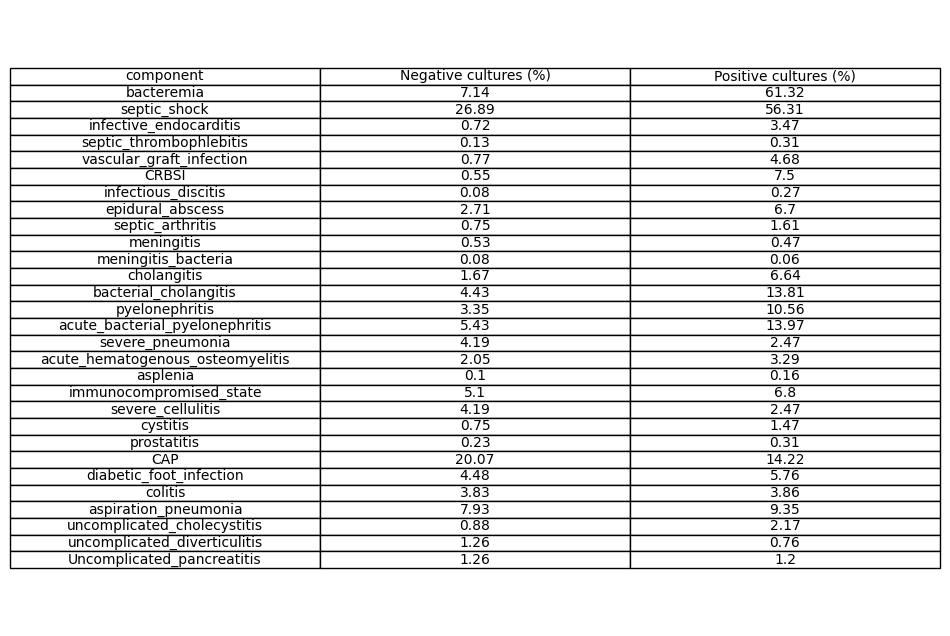

In [118]:
from tabulate import tabulate
components = [
    'bacteremia', 'septic_shock', 'infective_endocarditis',
    'septic_thrombophlebitis', 'vascular_graft_infection', 'CRBSI',
    'infectious_discitis', 'epidural_abscess', 'septic_arthritis',
    'meningitis', 'meningitis_bacteria', 'cholangitis',
    'bacterial_cholangitis', 'pyelonephritis',
    'acute_bacterial_pyelonephritis', 'severe_pneumonia',
    'acute_hematogenous_osteomyelitis', 'asplenia',
    'immunocompromised_state', 'severe_cellulitis', 'cystitis',
    'prostatitis', 'CAP', 'diabetic_foot_infection', 'colitis',
    'aspiration_pneumonia', 'uncomplicated_cholecystitis',
    'uncomplicated_diverticulitis', 'Uncomplicated_pancreatitis'
]

# Create a list to store the results
results = []

# Calculate percentages for each component
for component in components:
    neg_percentage = neg[neg[component]==1].order_proc_id_coded.nunique() / neg.order_proc_id_coded.nunique() * 100
    pos_percentage = pos[pos[component]==1].order_proc_id_coded.nunique() / pos.order_proc_id_coded.nunique() * 100
    results.append({'component': component, 'neg': neg_percentage, 'pos': pos_percentage})

# Convert results list to a DataFrame
result_df = pd.DataFrame(results)

result_df['neg']=result_df['neg'].apply(lambda x:round(x,2))
result_df['pos']=result_df['pos'].apply(lambda x:round(x,2))

# Print the resulting DataFrame as a table
print(tabulate(result_df, headers=['component','Negative cultures (%)','Positive cultures (%)',], tablefmt='grid'))

# Optionally, display the DataFrame directly (useful in Jupyter Notebooks)
from IPython.display import display


# Plot the DataFrame as a table using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))  # set size frame
#ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=result_df.values, colLabels=['component','Negative cultures (%)','Positive cultures (%)'], cellLoc='center', loc='center')

# Save the plot as an image
plt.savefig('component_percentages.png')

# Optionally display the plot
plt.show()